##MAIN TASK : try to detect your fingers and count the numbers what you are going to show and display it. 


In [1]:
!lsb_release -a

LSB Version:	:core-4.1-amd64:core-4.1-noarch:cxx-4.1-amd64:cxx-4.1-noarch:desktop-4.1-amd64:desktop-4.1-noarch:languages-4.1-amd64:languages-4.1-noarch:printing-4.1-amd64:printing-4.1-noarch
Distributor ID:	Fedora
Description:	Fedora release 35 (Thirty Five)
Release:	35
Codename:	ThirtyFive


In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import pairwise
#from google.colab.patches import cv2_imshow

##The image of hands with different number of straightened fingers is given.

In [161]:
# download image
!wget https://www.products-liability-insurance.com/wp-content/uploads/2017/11/5Steps.jpg

--2022-04-27 16:14:36--  https://www.products-liability-insurance.com/wp-content/uploads/2017/11/5Steps.jpg
Resolving www.products-liability-insurance.com (www.products-liability-insurance.com)... 35.209.208.145
Connecting to www.products-liability-insurance.com (www.products-liability-insurance.com)|35.209.208.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 773940 (756K) [image/jpeg]
Saving to: ‘5Steps.jpg’

5Steps.jpg          100%[===================>] 755.80K  67.3KB/s    in 13s     

2022-04-27 16:14:50 (58.5 KB/s) - ‘5Steps.jpg’ saved [773940/773940]



##The parameters of one region of interest (ROI) are given. But you need to create ROI for each hand

In [162]:
# Vertex of the region of interest (ROI)
roi_left   = 350+340 # x1
roi_top    = 70  # y1
# Opposite to first vertex
roi_right  = 700+320 # x2
roi_bottom = 700 # y2

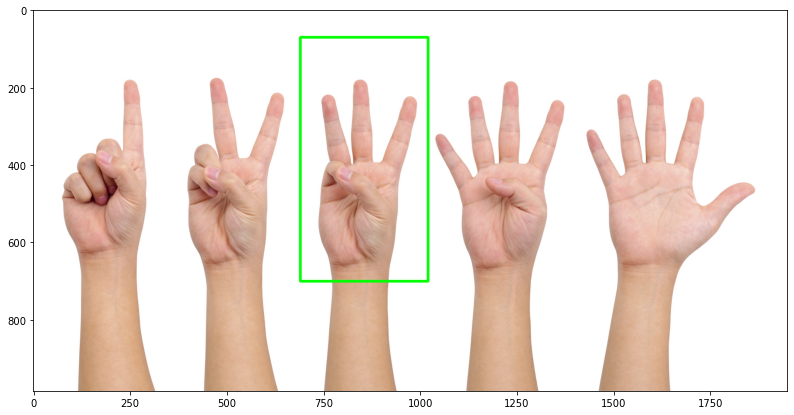

In [163]:
img = cv2.imread("5Steps.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (20, 7))
cv2.rectangle(img, pt1=(roi_left,roi_top), pt2=(roi_right,roi_bottom), color=(0,255,0), thickness=5)
plt.imshow(img)

##Segmenting the ROI (Hand)
The background image will be subtracted from the current image. Hence the Region of Interest will be detected using Contours in black and white image. 

In [164]:
def segment(gray_frame, threshold = 229):
    ret, thresholded_img = cv2.threshold(gray_frame, threshold, 255, cv2.THRESH_BINARY_INV)
    contours, hierarchy = cv2.findContours(thresholded_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    else:
        #Assuming the largest external contour in roi is the hand
        hand_segment = max(contours, key = cv2.contourArea)
        return (thresholded_img, hand_segment)

## TASK 1 : Write the missing code!

##Counting Fingers
Now each hand is detected but to count the numbers based on your fingers we still miss to segment separate fingers. Only then when one finger is folded we can use keep a track and count it. To do that we are going to use Convex hull function. Using Convex hull we wil be able to find the extreme point of your detected hand and then based on contours and extreme positions our job will become easier to count.

In [165]:
#Function to count fingers using Convexhull

def count_fingers(thresholded_img, hand_segment):
    
    conv_hull = cv2.convexHull(hand_segment)
    
    #most extreme top,bottom,left and right points
    top    = tuple(conv_hull[conv_hull[:, :, 1].argmin()][0])
    bottom = tuple(conv_hull[conv_hull[:, :, 1].argmax()][0])
    left   = tuple(conv_hull[conv_hull[:, :, 1].argmin()][0])
    right  = tuple(conv_hull[conv_hull[:, :, 1].argmax()][0])
    
    #finding center point
    cx = (left[0] + right[0]) // 2
    cy = (top[1] + bottom[1]) // 2
    
    #calculate distance from center to all extreme points
    distance = pairwise.euclidean_distances([(cx,cy)], Y=[left,right,top,bottom])[0]
    
    #calculate one of the max distance
    max_distance = distance.max()
    
    #create circle 
    radius = int(0.8 * max_distance)
    circumference = (2 * np.pi * radius)
    
    circular_roi = np.zeros(thresholded_img.shape[:2],dtype='uint8')
    
    cv2.circle(circular_roi, (cx,cy), radius, 255, 10)
    
    circular_roi = cv2.bitwise_and(thresholded_img,thresholded_img, mask = circular_roi)

    contours, hierarchy = cv2.findContours(circular_roi.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    count = 0
    
    for cnt in contours:
        (x, y, w, h) = cv2.boundingRect(cnt)
        out_of_wrist = ((cy + (cy * 0.3)) > (y + h))
        limit_points = ((circumference * 0.3) > cnt.shape[0])
        if out_of_wrist and limit_points:
            count += 1
            
    return count


##TASK 2 : Visualize the results of intermediate calculations of this function!

##TASK 3 : You need to draw the contour and area of interest, as well as the counting result for one of the hands. Write the missing code!

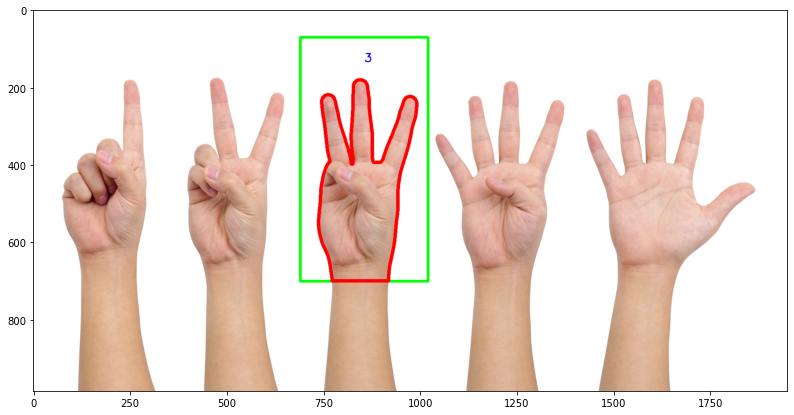

In [166]:
frame = cv2.imread("5Steps.jpg")
frame_copy = frame.copy()

roi = cv2.rectangle(frame_copy, (roi_left,roi_top), (roi_right,roi_bottom), (0,255,0), 5)

roi = frame[roi_top:roi_bottom, roi_left:roi_right]

gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

hand = segment(gray_roi)

thresholded, hand_segment = hand

cv2.drawContours(frame_copy, [hand_segment + [roi_left, roi_top]], -1, (0, 0, 255), 8)
fingers = count_fingers(thresholded, hand_segment)

cxText = int(((roi_right - roi_left) / 2) + roi_left)
cyText = int(((roi_bottom - roi_top) / 10) + roi_top)

cv2.putText(frame_copy, str(fingers), (cxText, cyText), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)

plt.figure(figsize = (20, 7))
plt.imshow(frame_copy, 'gray', vmin = 0, vmax = 255)

##TASK 4 : You need to draw the contour, the area of interest, as well as the cointing result for each of the hands. Write the missing code! If the count_fingers function does not work correctly, edit the function!

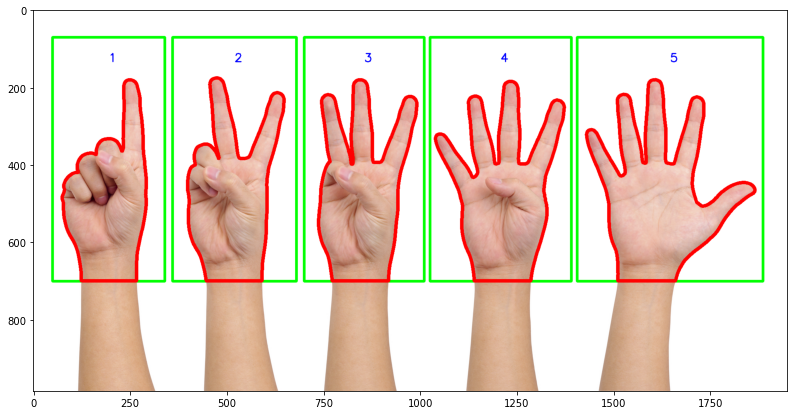

In [167]:
frame = cv2.imread("5Steps.jpg")
frame_copy = frame.copy()

# Vertexes of the region of interest (ROI) for each hand
hand_0_roi_left = 50
hand_0_roi_right = 50+290
hand_0_roi_top = 70
hand_0_roi_bottom = 700

hand_1_roi_left = 360
hand_1_roi_right = 360+320
hand_1_roi_top = 70
hand_1_roi_bottom = 700

hand_2_roi_left = 700
hand_2_roi_right = 700+310
hand_2_roi_top = 70
hand_2_roi_bottom = 700

hand_3_roi_left = 1025
hand_3_roi_right = 1025+365
hand_3_roi_top = 70
hand_3_roi_bottom = 700

hand_4_roi_left = 1405
hand_4_roi_right = 1405+480
hand_4_roi_top = 70
hand_4_roi_bottom = 700

#Draw rectange around each hand's ROI
hand_0_roi = cv2.rectangle(frame_copy, (hand_0_roi_left,hand_0_roi_top),
    (hand_0_roi_right,hand_0_roi_bottom), (0,255,0), 5)
hand_1_roi = cv2.rectangle(frame_copy, (hand_1_roi_left,hand_1_roi_top),
    (hand_1_roi_right,hand_1_roi_bottom), (0,255,0), 5)
hand_2_roi = cv2.rectangle(frame_copy, (hand_2_roi_left,hand_2_roi_top),
    (hand_2_roi_right,hand_2_roi_bottom), (0,255,0), 5)
hand_3_roi = cv2.rectangle(frame_copy, (hand_3_roi_left,hand_3_roi_top),
    (hand_3_roi_right,hand_3_roi_bottom), (0,255,0), 5)
hand_4_roi = cv2.rectangle(frame_copy, (hand_4_roi_left,hand_4_roi_top),
    (hand_4_roi_right,hand_4_roi_bottom), (0,255,0), 5)

#Store ROI values for each hand
hand_0_roi = frame[hand_0_roi_top:hand_0_roi_bottom, hand_0_roi_left:hand_0_roi_right]
hand_1_roi = frame[hand_1_roi_top:hand_1_roi_bottom, hand_1_roi_left:hand_1_roi_right]
hand_2_roi = frame[hand_2_roi_top:hand_2_roi_bottom, hand_2_roi_left:hand_2_roi_right]
hand_3_roi = frame[hand_3_roi_top:hand_3_roi_bottom, hand_3_roi_left:hand_3_roi_right]
hand_4_roi = frame[hand_4_roi_top:hand_4_roi_bottom, hand_4_roi_left:hand_4_roi_right]

#Turn each hand's ROI color to gray
hand_0_gray_roi = cv2.cvtColor(hand_0_roi, cv2.COLOR_BGR2GRAY)
hand_1_gray_roi = cv2.cvtColor(hand_1_roi, cv2.COLOR_BGR2GRAY)
hand_2_gray_roi = cv2.cvtColor(hand_2_roi, cv2.COLOR_BGR2GRAY)
hand_3_gray_roi = cv2.cvtColor(hand_3_roi, cv2.COLOR_BGR2GRAY)
hand_4_gray_roi = cv2.cvtColor(hand_4_roi, cv2.COLOR_BGR2GRAY)

#Find contour for each hand
hand_0 = segment(hand_0_gray_roi)
hand_1 = segment(hand_1_gray_roi)
hand_2 = segment(hand_2_gray_roi)
hand_3 = segment(hand_3_gray_roi)
hand_4 = segment(hand_4_gray_roi)

#Store ROI and its thresholded image for each hand
hand_0_thresholded, hand_0_segment = hand_0
hand_1_thresholded, hand_1_segment = hand_1
hand_2_thresholded, hand_2_segment = hand_2
hand_3_thresholded, hand_3_segment = hand_3
hand_4_thresholded, hand_4_segment = hand_4

#Draw contours around each hand
cv2.drawContours(frame_copy, [hand_0_segment + [hand_0_roi_left, hand_0_roi_top]], -1, (0, 0, 255), 8)
cv2.drawContours(frame_copy, [hand_1_segment + [hand_1_roi_left, hand_1_roi_top]], -1, (0, 0, 255), 8)
cv2.drawContours(frame_copy, [hand_2_segment + [hand_2_roi_left, hand_2_roi_top]], -1, (0, 0, 255), 8)
cv2.drawContours(frame_copy, [hand_3_segment + [hand_3_roi_left, hand_3_roi_top]], -1, (0, 0, 255), 8)
cv2.drawContours(frame_copy, [hand_4_segment + [hand_4_roi_left, hand_4_roi_top]], -1, (0, 0, 255), 8)

#Count fingers on each hand
hand_0_fingers = count_fingers(hand_0_thresholded, hand_0_segment)
hand_1_fingers = count_fingers(hand_1_thresholded, hand_1_segment)
hand_2_fingers = count_fingers(hand_2_thresholded, hand_2_segment)
hand_3_fingers = count_fingers(hand_3_thresholded, hand_3_segment)
hand_4_fingers = count_fingers(hand_4_thresholded, hand_4_segment)

#Calculate x and y coordinates for finger count's text for each hand
hand_0_cxText = int(((hand_0_roi_right - hand_0_roi_left) / 2) + hand_0_roi_left)
hand_0_cyText = int(((hand_0_roi_bottom - hand_0_roi_top) / 10) + hand_0_roi_top)

hand_1_cxText = int(((hand_1_roi_right - hand_1_roi_left) / 2) + hand_1_roi_left)
hand_1_cyText = int(((hand_1_roi_bottom - hand_1_roi_top) / 10) + hand_1_roi_top)

hand_2_cxText = int(((hand_2_roi_right - hand_2_roi_left) / 2) + hand_2_roi_left)
hand_2_cyText = int(((hand_2_roi_bottom - hand_2_roi_top) / 10) + hand_2_roi_top)

hand_3_cxText = int(((hand_3_roi_right - hand_3_roi_left) / 2) + hand_3_roi_left)
hand_3_cyText = int(((hand_3_roi_bottom - hand_3_roi_top) / 10) + hand_3_roi_top)

hand_4_cxText = int(((hand_4_roi_right - hand_4_roi_left) / 2) + hand_4_roi_left)
hand_4_cyText = int(((hand_4_roi_bottom - hand_4_roi_top) / 10) + hand_4_roi_top)

#Print finger count text above each hand
cv2.putText(frame_copy, str(hand_0_fingers), (hand_0_cxText, hand_0_cyText),
    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.putText(frame_copy, str(hand_1_fingers), (hand_1_cxText, hand_1_cyText),
    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.putText(frame_copy, str(hand_2_fingers), (hand_2_cxText, hand_2_cyText),
    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.putText(frame_copy, str(hand_3_fingers), (hand_3_cxText, hand_3_cyText),
    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)
cv2.putText(frame_copy, str(hand_4_fingers), (hand_4_cxText, hand_4_cyText),
    cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2)

#Import frame from BGR to RGB
frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)

#Show final result (image)
plt.figure(figsize = (20, 7))
plt.imshow(frame_copy, 'gray', vmin = 0, vmax = 255)